# <center>Построение каркаса позы через ключевые точки

In [1]:
import torch
from torchvision import models
import torchvision.transforms as T
import matplotlib as plt
import numpy as np
import cv2
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Torch using {DEVICE}')

Torch using cuda


## Модель Keypoint RCNN
Для создания *Human Pose Skeleton* можно воспользоваться архитектурой **Keypoint RCNN**, имплементация которой представлена в библиотеке *torchvision*.

Модель обучена на наборе данных **MS-COCO (Common Objects in Context)** с целью обнаружения 17 ключевых точек человеческого тела (нос, глаза, уши, плечи, локти, запястья, бёдра, колени и лодыжки).

Архитектура *Keypoint RCNN* представлена на рисунке ниже.

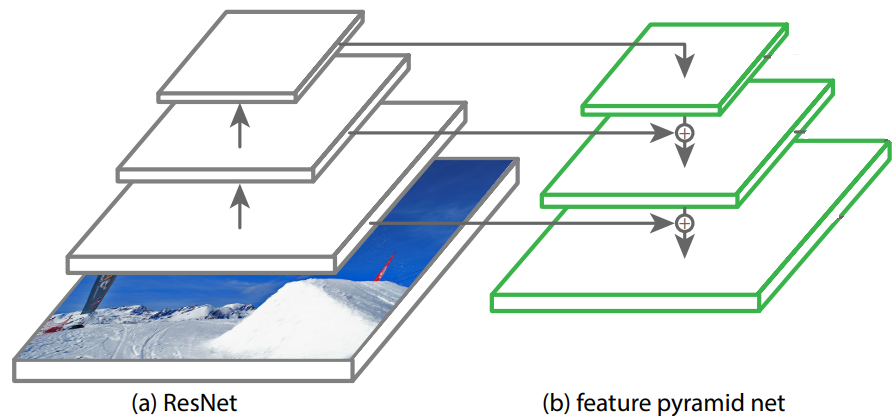

Модель выводит список из следующих элементов:

* `boxes` — тензор размера `[N, 4]`, где `N` — количество обнаруженных объектов.
* `labels` — тензор размера `[N]`, класс объекта. Он всегда равен `1`, так как каждый обнаруженный «ящик» указывает на человека. `0` обозначает фоновый класс.
* `scores` — тензор размера `[N]`, отображающий показатель достоверности обнаруженного объекта.
* `keypoints` — тензор размера `[N, 17, 3]`, отображающий `17` ключевых точек `N` человек. Первые два числа — координаты `x` и `y`, а третье — видимость.
* `keypoints_scores` — тензор размера `[N, 17]`, отражающий оценку всех ключевых точек для каждого обнаруженного человека.


In [2]:
model = models.detection.keypointrcnn_resnet50_fpn(
    weights=models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
).eval().to(DEVICE)

In [3]:
keypoints = [
    'nose','left_eye','right_eye',
    'left_ear','right_ear','left_shoulder',
    'right_shoulder','left_elbow','right_elbow',
    'left_wrist','right_wrist','left_hip',
    'right_hip','left_knee', 'right_knee',
    'left_ankle','right_ankle'
]

transforms = T.Compose([
    T.ToTensor()
])

In [4]:
# BGR -> RGB
input_image = cv2.cvtColor(cv2.imread(filename='data/stretchen-stretch-heat-sport.jpg'), code=cv2.COLOR_BGR2RGB)
# [H, W, C] -> [B, H, W, C] for single image
transformed_input = transforms(input_image)[None, ...].to(DEVICE)
transformed_input.shape

torch.Size([1, 3, 607, 910])

In [5]:
# Forward pass
output = model(transformed_input)
output

[{'boxes': tensor([[124.3726,  12.3511, 803.7053, 540.9943],
          [498.6067,  14.7330, 843.3099, 570.6264],
          [126.4030, 101.4247, 532.2675, 510.6596]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9985, 0.2356, 0.1542], device='cuda:0', grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[442.4307, 341.1414,   1.0000],
           [450.7708, 335.8322,   1.0000],
           [450.7708, 337.3491,   1.0000],
           [430.2998, 322.1800,   1.0000],
           [495.5036, 295.6341,   1.0000],
           [406.7960, 231.1654,   1.0000],
           [637.2839,  40.7931,   1.0000],
           [330.2195, 292.6003,   1.0000],
           [327.9449, 355.5520,   1.0000],
           [246.8192, 341.1414,   1.0000],
           [717.6514, 278.9481,   1.0000],
           [408.3124, 200.8271,   1.0000],
           [413.6197, 210.6871,   1.0000],
           [472.7581, 360.8612,   1.0000],
           [341.5922, 344.175

In [6]:
# Joint connections
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs

In [7]:
def draw_skeleton_per_person(
    img,
    all_keypoints,
    all_scores,
    confs,
    limbs,
    # keypoint_threshold=2,
    conf_threshold=0.9
):
    # создаём спектр цветов
    # cmap = plt.colormaps['rainbow']
    # создаём копию изображений
    img_copy = img.copy()
    # color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
            # print(color)
            # итерируем по каждому скору
            # for kp in range(len(scores)):
            #     # проверяем степень уверенности детектора опорной точки
            #     if scores[kp] > keypoint_threshold:
            #         # конвертируем массив ключевых точек в список целых чисел
            #         keypoint = tuple(
            #             map(int, keypoints[kp, :2].cpu())
            #         )
            #         # выбираем цвет
            #         color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
            #         # рисуем кружок радиуса 5 вокруг точки
            #         cv2.circle(img_copy, keypoint, 5, color, -1)
            for joint in limbs:
                # if all(map(lambda kp_score: kp_score > keypoint_threshold, scores[joint])):
                    pt1, pt2 = [tuple(map(int, keypoints[joint_idx, :2].cpu())) for joint_idx in joint]
                    cv2.line(img_copy, pt1, pt2, (0, 255, 255), 3)
    return img_copy

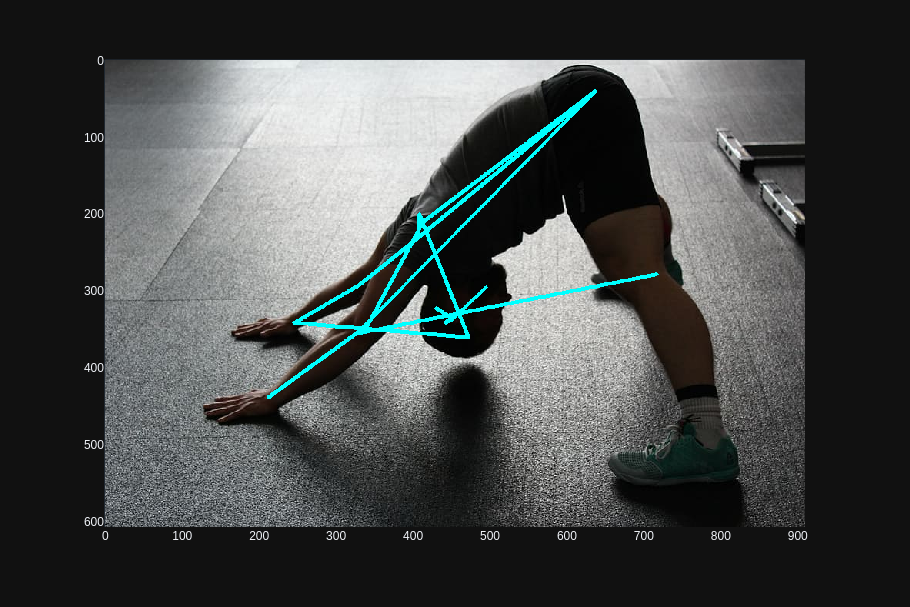

In [8]:
limbs = get_limbs_from_keypoints(keypoints)
px.imshow(
    draw_skeleton_per_person(
        img=input_image,
        all_keypoints=output[0]['keypoints'],
        all_scores=output[0]['keypoints_scores'],
        confs=output[0]['scores'],
        limbs=limbs
    ),
    height=input_image.shape[0],
    width=input_image.shape[1]
)

# <center>Оценка сходства поз по фотографии
## Постановка задачи
Идея в том, что коуч задаёт человеку модельную позу, которую он должен попытаться повторить. После фотографирования решается, соответствует ли входная поза позе коуча.

Итак, у нас есть два набора ключевых точек:

* Модельный набор (который нужно имитировать).
* Ввод (необходимо сопоставить его с модельным набором).

Как же сравнить эти два набора?

Задача сводится к тому, чтобы проверить формы поз на одинаковость. Для её решения можно использовать наложение Прокруста, которое выполняется путём оптимального перемещения, вращения и равномерного масштабирования объектов. Другими словами, свободно регулируется как размещение в пространстве, так и размер объектов. Цель состоит в том, чтобы получить аналогичное размещение и размер, минимизируя меру различия формы, называемую **прокрустовым расстоянием** между объектами.

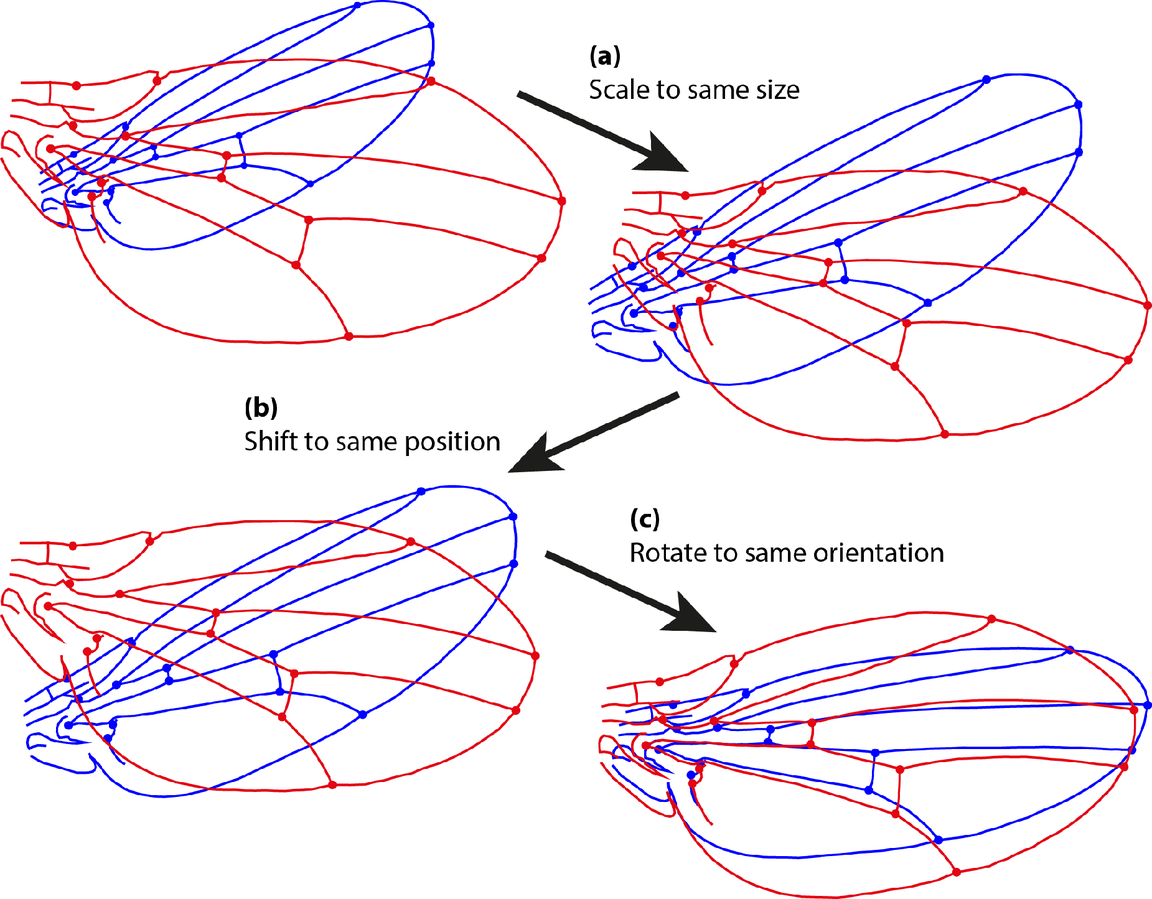

Итак, нам необходима **комбинация переноса, масштабирования и поворота**, которая лучше всего преобразует исходную позу в позу модели. В линейной алгебре такая комбинация представлена **аффинным преобразованием**.

**Свойства аффинного преобразования:**
* линии сопоставляются с линиями;
* параллельные линии остаются параллельными;
* исходный вектор не обязательно отображается в исходный;
* соотношения сохраняются.
 
После того как преобразование входного изображения применено, мы можем использовать метрики расстояния для оценки сходства выполненных действий на фотографиях.



**Аффинное отображение** (преобразование) $f$ входного вектора $x$ в модельный вектор $y$ выглядит следующим образом:
$$ y = f(x) = Ax + b $$
С помощью расширенной матрицы можно умножить вектор $x$ на матрицу $A$ и добавить вектора $b$ за счёт единственного матричного умножения.

Эта расширенная матрица создаётся следующим образом:

1. Дополняем все векторы «1» в конце.
2. Дополняем матрицу строкой нулей внизу.
3. Дополняем матрицу столбцом (вектором переноса) справа и «1» в правом нижнем углу.


```py
# Соберём два набора ключевых точек
model_key_points = [[x1,y2],[x2,y2],...]
input_key_points = [[x1,y2],[x2,y2],...]
 
# С помощью расширенной матрицы можно осуществить умножение вектора x на матрицу A и добавление вектора b за счёт единственного матричного умножения.
# Расширенная матрица создаётся путём дополнения векторов "1" в конце.
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]
 
# Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]
Y = pad(model_key_points)
X = pad(input_key_points)
```

В нашем случае `X` (входная поза) и `y` (поза модели) известны и мы хотим найти расширенную матрицу. Используя алгоритм наименьших квадратов (который минимизирует сумму квадратов), мы можем аппроксимировать решение этой линейной системы и найти матрицу аффинного преобразования.

```py
# Решим задачу наименьших квадратов X * A = Y
# и найдём матрицу аффинного преобразования A.
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

# Теперь, когда мы нашли расширенную матрицу A,
# мы можем преобразовать входной набор ключевых точек
transform = lambda x: unpad(np.dot(pad(x), A))
input_transform = transform(input_key_points)
```

Итак, при сравнении поз на двух картинках стоит учитывать, что изображения могут иметь разный размер, человек может появиться в разных местах фотографии и т. д. С помощью аффинного отображения мы получили преобразованный набор ключевых точек, необходимый для корректного сравнения позы спортсмена с модельной. Пришло время перейти к оценке «сходства» двух поз.





## Косинусное сходство и взвешенное совпадение
Теперь, когда у нас есть преобразованный вход `X`, мы можем сравнить его с позой модели. Для определения «сходства» `X` и `y` можно воспользоваться **косинусным сходством** и **взвешенным совпадением** с учётом показателей достоверности ключевых точек.

>**Косинусное сходство** — это мера сходства между двумя векторами: в основном оно измеряет угол между ними и возвращает -1, если они прямо противоположны, и 1, если они абсолютно одинаковы. Важно отметить, что это мера ориентации, а не величины.

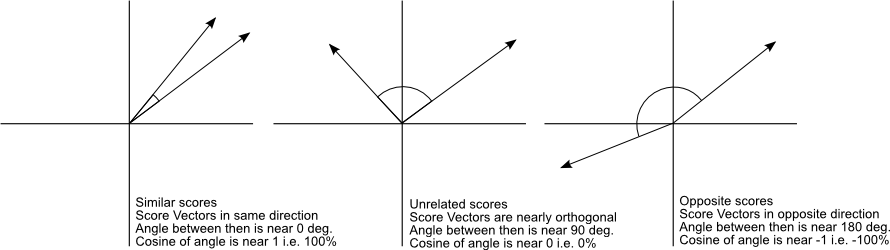

>**Взвешенное совпадение** позволяет учесть степень достоверности ключевой точки: соединения с низкой достоверностью должны оказывать меньшее влияние на показатель совпадения, чем соединения с высокой степенью достоверности.

Благодаря алгоритмам сходства, таким как косинусное сходство и взвешенное совпадение, мы можем анализировать близость между двумя оценками позы человека. Сходство косинуса рассчитывается путём создания векторов поз и оценки косинуса угла между ними. Взвешенное совпадение учитывают оценку достоверности каждой отдельно найденной ключевой точки так, чтобы более реалистичные ключевые точки в большей степени влияли на результат.



In [9]:
def cosine_distance(pose1, pose2):
    cossin = (pose1 @ pose2) / (np.linalg.norm(pose1) * np.linalg.norm(pose2))
    return cossin


def weight_distance(pose1, pose2, conf1):
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||) = sum1 * sum2

    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    for i in range(len(pose1)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = np.floor(i / 2)
        sum2 = conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

# <center>Валидация оценки позы на видео

In [10]:
input_video_path = 'data/videoplayback.mp4'
cap = cv2.VideoCapture(input_video_path)
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
print(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.avi', fourcc, 25, (1280, 720))
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    transformed_input = transforms(frame)[None, ...].to(DEVICE)
    output = model(transformed_input)
    skeleton_frame = draw_skeleton_per_person(
        img=frame,
        all_keypoints=output[0]['keypoints'],
        all_scores=output[0]['keypoints_scores'],
        confs=output[0]['scores'],
        limbs=limbs
    )
    out.write(skeleton_frame)

720.0
Can't receive frame (stream end?). Exiting ...
